In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

from io import BytesIO

%matplotlib inline

## Load Data

In [2]:
source = 'https://docs.google.com/spreadsheets/d/\
1rLAZH7wN9DkigkFD070gy5YbEPr-RPQaqPvnePrh31E/edit#gid=30186846'

src = 'https://docs.google.com/spreadsheets/d/e/\
2PACX-1vRTnUtD0mWB48f30XW9HshTaO8ck6m52o2-\
6llWJUzgqx_9yDNr5AGrmgFzrAyBcf2drly92yatnjg9/\
pub?gid=30186846&single=true&output=csv'

df = pd.read_csv(src)

# format date columns
for col in ['DateRepConf', 'DateRecover', 'DateDied', 'DateRepRem']:
    df[col] = pd.to_datetime(df[col])
df.head()

,CaseCode,Age,AgeGroup,Sex,DateRepConf,DateRecover,DateDied,RemovalType,DateRepRem,Admitted,RegionRes,ProvCityRes
0,C404174,38.0,35 to 39,Female,2020-01-30,2020-08-02,NaT,Recovered,2020-02-10,NaN,Negros Oriental,Dumaguete City (Capital)
1,C462688,44.0,40 to 44,Male,2020-02-03,NaT,2020-01-02,Died,2020-02-02,NaN,Negros Oriental,Dumaguete City (Capital)
2,C387710,60.0,60 to 64,Female,2020-02-05,2020-01-31,NaT,Recovered,2020-02-10,Yes,Bohol,Panglao
3,C377460,48.0,45 to 49,Male,2020-03-06,2020-03-19,NaT,Recovered,2020-03-27,Yes,NCR,Taguig City
4,C498051,62.0,60 to 64,Male,2020-03-06,NaT,2020-11-03,Died,2020-03-12,Yes,Rizal,Cainta


## Latest Statistics

In [3]:
total_cases = len(df)
recovered = len(df.loc[df.RemovalType=='Recovered'])
died = len(df.loc[df.RemovalType=='Died'])
active_cases = total_cases - recovered - died
percent_active = active_cases / total_cases
percent_recovered = recovered / total_cases
percent_died = died / total_cases

print(f'Total Cases: {total_cases}, \nActive Cases: {active_cases}\
({100*percent_active:.1f}% of total cases)\n\
Recovered: {recovered} ({100*percent_recovered:.1f}% of total cases)\n\
Died: {died} ({100*percent_died:.1f}% of total cases)')

Total Cases: 5453, 
Active Cases: 4822(88.4% of total cases)
Recovered: 295 (5.4% of total cases)
Died: 336 (6.2% of total cases)


## Daily Trend of Total and Active Cases,  Recovered, and Died

### Total Cases Per Day

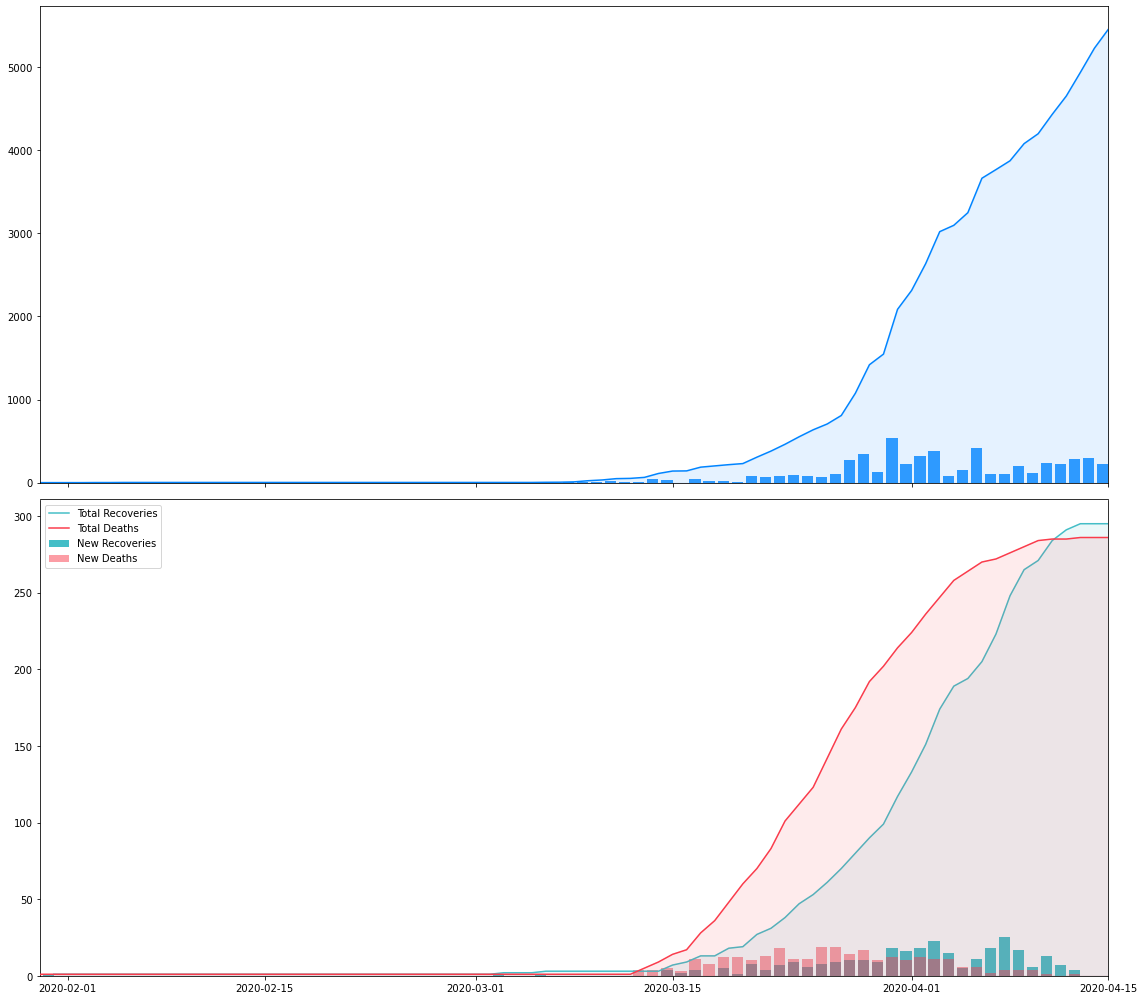

In [4]:
fig, ax = plt.subplots(2, figsize=(16, 14), sharex=True)

cases_per_day = (df.groupby('DateRepConf')['CaseCode']
                 .count().resample('1D').sum())

ax_ = ax[0]
x = cases_per_day.index.date
ax_.plot(x, cases_per_day.cumsum(), color='#0084ff',
        label='Total Number of Cases')
ax_.fill_between(x, y1=0, y2=cases_per_day.cumsum(), alpha=.1,
                color='#0084ff', label='Total Number of Cases')
ax_.bar(x, cases_per_day, color='#0084ff', alpha=.8,
       label='Number of New Cases', align='edge', width=-.8)
ax_.set_ylim(0,)
ax_.set_xlim(cases_per_day.index[0], cases_per_day.index[-1])

# recoveries
recoveries_per_day = (df.dropna(subset=['DateRecover'])
                      .groupby('DateRecover')['CaseCode']
                      .count().resample('1D').sum())

x = recoveries_per_day.index.date
ax_ = ax[1]
ax_.plot(x, recoveries_per_day.cumsum(),
         color='#44bec7', label='Total Recoveries', zorder=2)
ax_.fill_between(x, y1=0, y2=recoveries_per_day.cumsum(),
                 color='#44bec7', label='', alpha=.1, zorder=2)
ax_.bar(x, recoveries_per_day, color='#44bec7', alpha=1,
        label='New Recoveries', align='edge', width=-.8, zorder=0)

# deaths
deaths_per_day = (df.dropna(subset=['DateDied'])
                  .groupby('DateDied')['CaseCode']
                  .count().resample('1D').sum())

x = deaths_per_day.index.date
ax_.plot(x, deaths_per_day.cumsum(),
         color='#fa3c4c', label='Total Deaths', zorder=3)
ax_.fill_between(x, y1=0, y2=deaths_per_day.cumsum(),
                 color='#fa3c4c', label='', alpha=.1, zorder=3)
ax_.bar(x, deaths_per_day, color='#fa3c4c', alpha=.5,
        label='New Deaths', align='edge', width=-.8, zorder=1)
ax_.set_ylim(0,)
ax_.set_xlim(cases_per_day.index[0], cases_per_day.index[-1])
ax_.legend()

fig.tight_layout();

### Percent Active, Recovered, and Died

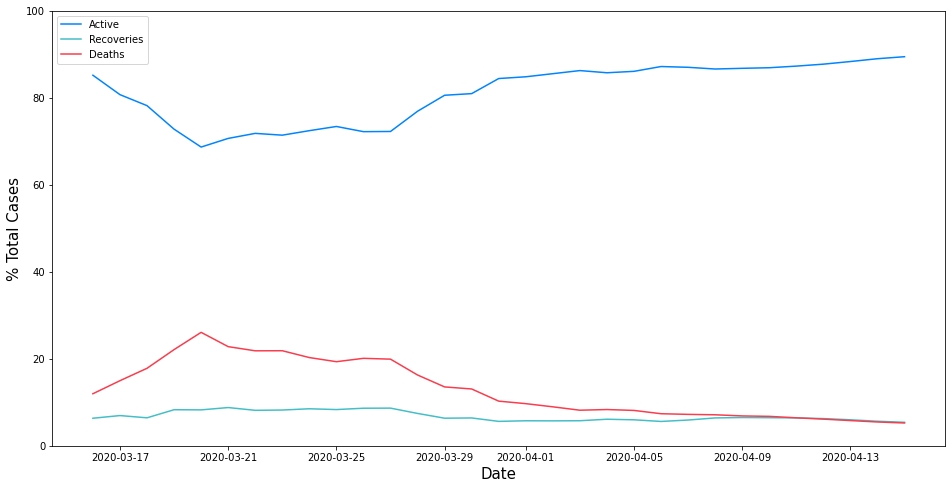

In [5]:
active_per_day = np.maximum(cases_per_day 
                            - recoveries_per_day 
                            - deaths_per_day, 0).fillna(0)
percent_active_per_day = (100 * active_per_day.cumsum() /
                          cases_per_day.cumsum())
percent_deaths_per_day = (100 * deaths_per_day.cumsum() /
                          cases_per_day.cumsum())
percent_recoveries_per_day = (100 * recoveries_per_day.cumsum() /
                              cases_per_day.cumsum())

fig, ax = plt.subplots(figsize=(16, 8))
x = cases_per_day.index[46:]
ax.plot(x, percent_active_per_day[x],
        color='#0084ff', label='Active')
ax.plot(x, percent_recoveries_per_day[x], color='#44bec7', label='Recoveries')
ax.plot(x, percent_deaths_per_day[x], color='#fa3c4c', label='Deaths')
ax.set_ylim(0, 100)
ax.set_xlabel('Date', size=15)
ax.set_ylabel('% Total Cases', size=15)
ax.legend();

### New Cases VS Total Cases

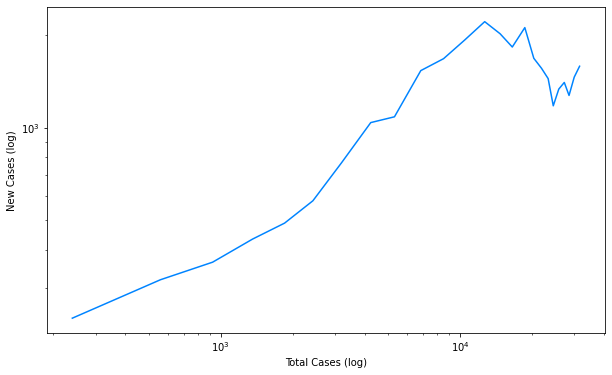

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.loglog(cases_per_day[x].rolling(window=7).sum().cumsum(),
          cases_per_day[x].rolling(window=7).sum(), color='#0084ff')
ax.set_xlabel('Total Cases (log)')
ax.set_ylabel('New Cases (log)');

### Rolling Bayesian Rt Estimate